## Введение

### Прогнозирование уровня удовлетворённости и оттока сотрудников компании «Работа с заботой»

<b>Описание исследования:</b>
В рамках проекта для компании «Работа с заботой» проведён анализ данных сотрудников с целью оптимизации управления персоналом. HR-аналитики компании стремятся минимизировать финансовые потери и отток сотрудников, используя методы машинного обучения для прогнозирования уровня удовлетворённости сотрудников работой и вероятности их увольнения. Данные включают характеристики сотрудников, такие как отдел, уровень должности, зарплата, стаж, а также целевые признаки: уровень удовлетворённости и статус увольнения.

<b>Цель исследования:</b>
Разработать модели машинного обучения для:
- Прогнозирования уровня удовлетворённости сотрудников на основе их характеристик.
- Предсказания вероятности увольнения сотрудников из компании.

<b>Суть исследования:</b>
Провести анализ данных сотрудников, построить предсказательные модели и выявить факторы, влияющие на удовлетворённость и отток, чтобы компания могла разработать стратегию удержания персонала и снижения финансовых рисков, связанных с внезапными увольнениями.

<b>Задачи исследования:</b>
- Провести предварительный анализ данных, включая обработку пропусков и преобразование категориальных признаков.
- Построить и обучить модель для предсказания job_satisfaction_rate.
- Построить и обучить модель для предсказания quit.
- Сформулировать рекомендации для бизнеса на основе результатов.


## Задача 1: предсказание уровня удовлетворённости сотрудника

## Импорт библиотек

In [1]:
!pip install -q imblearn
!pip install -q phik
!pip install -q shap
!pip install -q optuna
!pip install -q optuna.integration
!pip install -qU scikit-learn imbalanced-learn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import phik
from imblearn.over_sampling import SMOTENC
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, make_scorer
from optuna import distributions
from optuna.integration import OptunaSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.inspection import permutation_importance
import shap
import math
from sklearn.ensemble import RandomForestRegressor


In [3]:
plt.style.use('seaborn')

## Загрузка данных 

In [4]:
train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [5]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [6]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [7]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [8]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [9]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [10]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Типы данных корректны, в некоторых столбцах обнаружены пропуски, обработаем их в пайплайне. 

## Предобработка данных

Исследуем данные на дубликаты, для этого проверим наличие строк, которые полностью повторяют друг друга, а также изучим уникальные значения для категориальных признаков, чтобы не пропустить неявные дубликаты. 

In [11]:
train_job_satisfaction_rate.duplicated().sum()

0

In [12]:
def check_unique_values(df, columns):
    for col in columns:
        unique_vals = df[col].unique()
        print(f"Уникальные значения для {col}: {unique_vals}")        

        
categorical_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

check_unique_values(train_job_satisfaction_rate, categorical_columns)

Уникальные значения для dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения для level: ['junior' 'middle' 'sinior' nan]
Уникальные значения для workload: ['medium' 'high' 'low']
Уникальные значения для last_year_promo: ['no' 'yes']
Уникальные значения для last_year_violations: ['no' 'yes']


В таблице train_job_satisfaction_rate не найдено как явных, так и неявных дубликатов. В слове senior опечатка в одной букве, исправим, чтобы не возникло путаницы. 

In [13]:
train_job_satisfaction_rate['level'] = train_job_satisfaction_rate['level'].replace('sinior', 'senior')
check_unique_values(train_job_satisfaction_rate, categorical_columns)

Уникальные значения для dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения для level: ['junior' 'middle' 'senior' nan]
Уникальные значения для workload: ['medium' 'high' 'low']
Уникальные значения для last_year_promo: ['no' 'yes']
Уникальные значения для last_year_violations: ['no' 'yes']


In [14]:
test_features.duplicated().sum()

0

In [15]:
check_unique_values(test_features, categorical_columns)

Уникальные значения для dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения для level: ['junior' 'middle' 'sinior' nan]
Уникальные значения для workload: ['medium' 'low' 'high' ' ']
Уникальные значения для last_year_promo: ['no' 'yes']
Уникальные значения для last_year_violations: ['no' 'yes']


В таблице test_features явных дубликатов нет, однако в некоторых столбцах вместо значения nan стоит пробел, исправим это. Также, исправим орфографическую ошибку в слове senior. 

In [16]:
test_features[categorical_columns] = test_features[categorical_columns].replace(' ', np.nan)
test_features['level'] = test_features['level'].replace('sinior', 'senior')
check_unique_values(test_features, categorical_columns)

Уникальные значения для dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Уникальные значения для level: ['junior' 'middle' 'senior' nan]
Уникальные значения для workload: ['medium' 'low' 'high' nan]
Уникальные значения для last_year_promo: ['no' 'yes']
Уникальные значения для last_year_violations: ['no' 'yes']


In [17]:
test_target_job_satisfaction_rate.duplicated().sum()

0

В таблице test_target_job_satisfaction_rate явных дубликатов нет, а имеющиеся значения по столбцам могут повторять друг друга 

Итак, мы провели предобработку данных. Избавились от орфографических ошибок и неявных дубликатов, явных не обнаружено. Теперь перейдем к исследовательскому анализу. 

## Исследовательский анализ данных


Сначала изучим общую характеристику для количественных признаков

In [18]:
train_job_satisfaction_rate.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [19]:
test_features.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [20]:
test_target_job_satisfaction_rate.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


Подозрения вызывает признак salary, максимальное значение сильно выбивается относительно других в обеих таблицах. Изучим признаки более подробно отдельно для каждой таблицы. 

<b>train_job_satisfaction_rate</b>

In [21]:
continuous_columns = ['salary', 'job_satisfaction_rate']
discrete_columns = ['supervisor_evaluation', 'employment_years']
categorical_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
numeric_columns = continuous_columns + discrete_columns

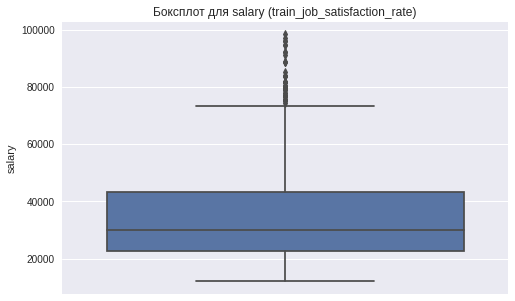

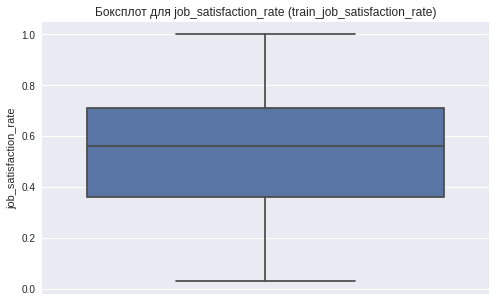

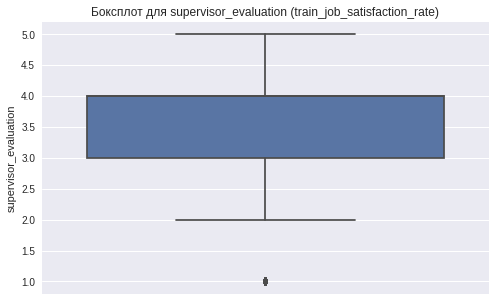

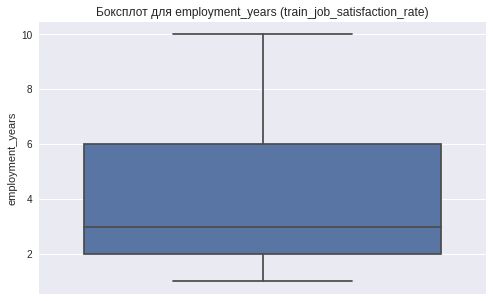

In [22]:
for col in numeric_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=train_job_satisfaction_rate, y=col)
    plt.title(f'Боксплот для {col} (train_job_satisfaction_rate)')
    plt.ylabel(col)
    plt.show()

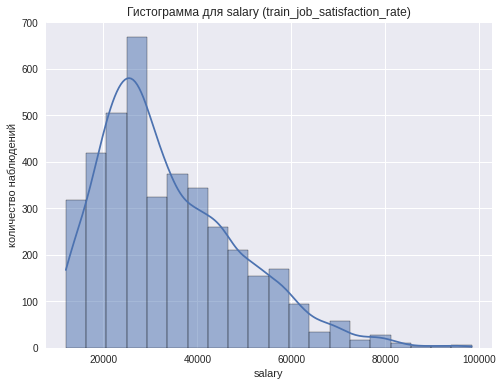

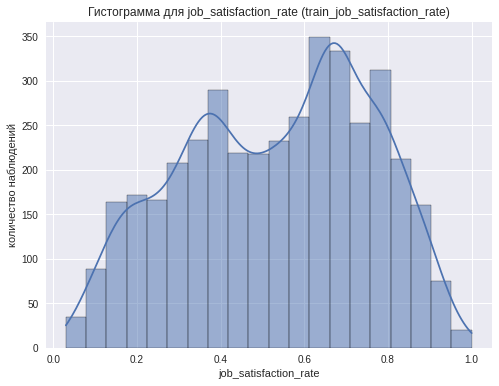

In [23]:
for col in continuous_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=train_job_satisfaction_rate, x=col, bins=20, kde=True)
    plt.title(f'Гистограмма для {col} (train_job_satisfaction_rate)')
    plt.xlabel(col)
    plt.ylabel('количество наблюдений')
    plt.show()

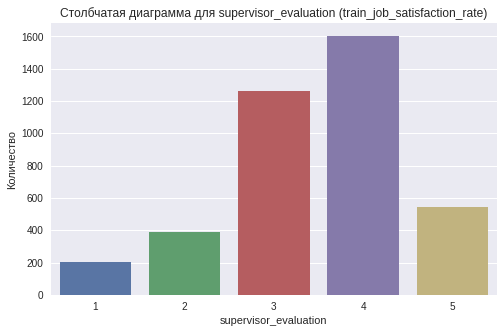

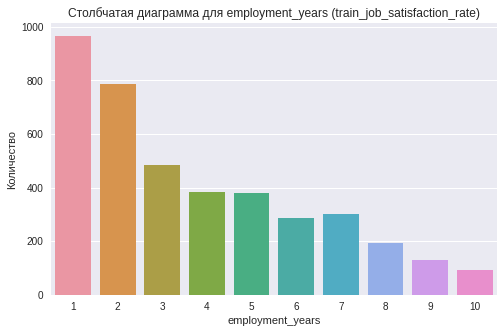

In [24]:
for col in discrete_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=train_job_satisfaction_rate, x=col)
    plt.title(f'Столбчатая диаграмма для {col} (train_job_satisfaction_rate)')
    plt.xlabel(col)
    plt.ylabel('Количество')
    plt.show()

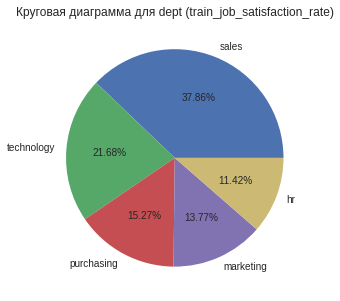

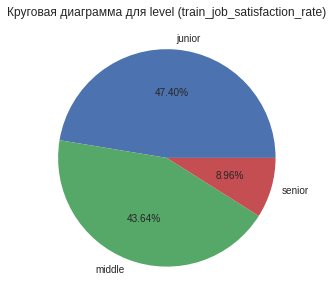

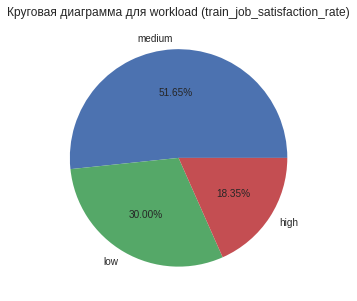

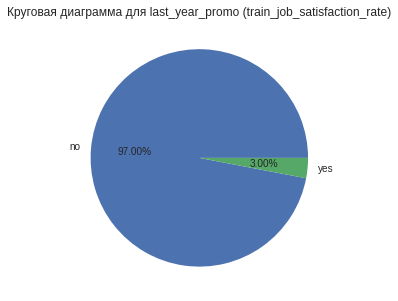

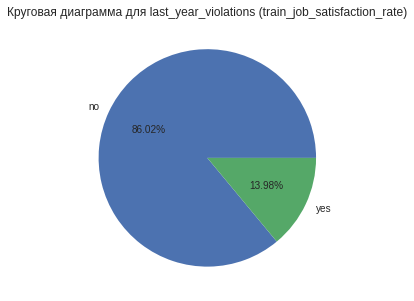

In [25]:
for col in categorical_columns:
    plt.figure(figsize=(8, 5))
    train_job_satisfaction_rate[col].value_counts().plot.pie(autopct='%1.2f%%')
    plt.title(f'Круговая диаграмма для {col} (train_job_satisfaction_rate)')
    plt.ylabel('')  
    plt.show()

В количесвенных данных есть выбросы, но выглядят они достаточно реалистично для бизнеса, всегда есть уникальные работники, оставим их, чтобы модель потом смогла работать с реальными данными. 

В категориальных признаках все соотносится реалистично, кроме признаков last_year_promo и last_year_violations. В них наблюдается сильный дисбаланс классов. 

<b>test_features</b>

In [26]:
continuous_columns = ['salary']
discrete_columns = ['employment_years', 'supervisor_evaluation']
categorical_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
numeric_columns = continuous_columns + discrete_columns

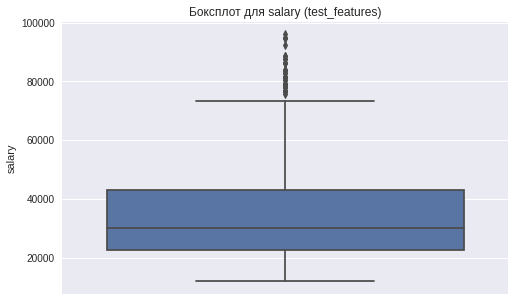

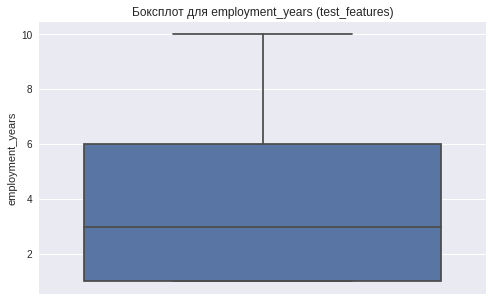

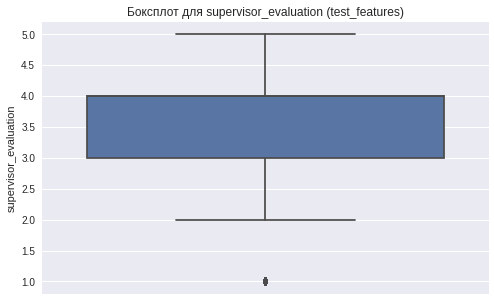

In [27]:
for col in numeric_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=test_features, y=col)
    plt.title(f'Боксплот для {col} (test_features)')
    plt.ylabel(col)
    plt.show()

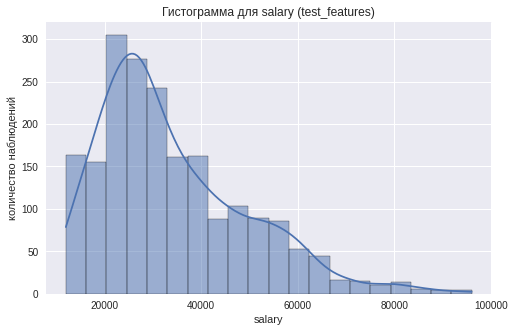

In [28]:
for col in continuous_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=test_features, x=col, bins=20, kde=True)
    plt.title(f'Гистограмма для {col} (test_features)')
    plt.xlabel(col)
    plt.ylabel('количество наблюдений')
    plt.show()

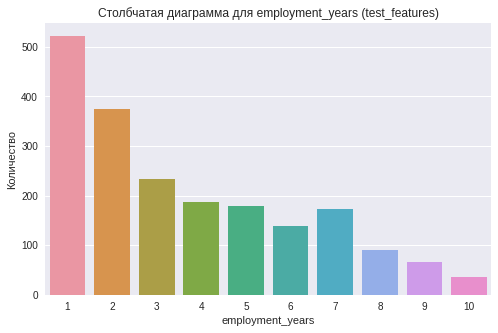

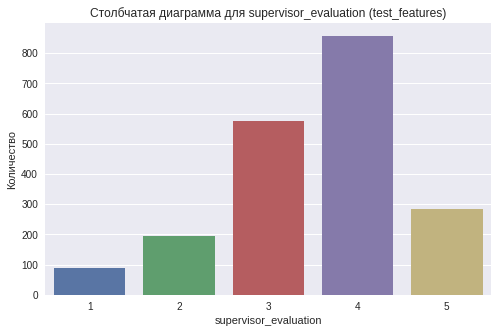

In [29]:
for col in discrete_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=test_features, x=col)
    plt.title(f'Столбчатая диаграмма для {col} (test_features)')
    plt.xlabel(col)
    plt.ylabel('Количество')
    plt.show()

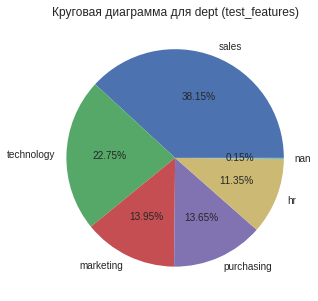

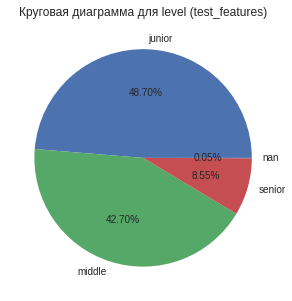

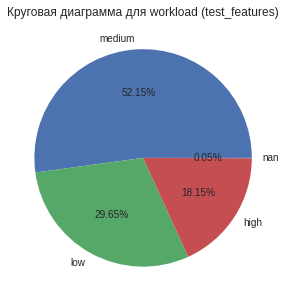

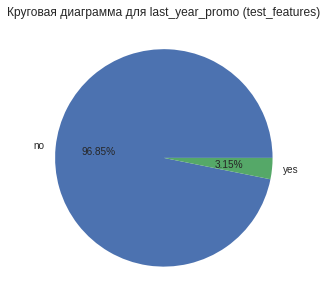

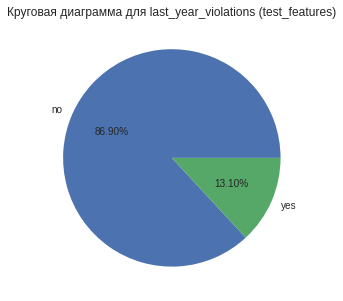

In [30]:
for col in categorical_columns:
    plt.figure(figsize=(8, 5))
    test_features[col].value_counts(dropna=False).plot.pie(autopct='%1.2f%%')
    plt.title(f'Круговая диаграмма для {col} (test_features)')
    plt.ylabel('') 
    plt.show()

В таблице test_features ситуация аналогична предыдущей. 

<b>test_target_job_satisfaction_rate</b>

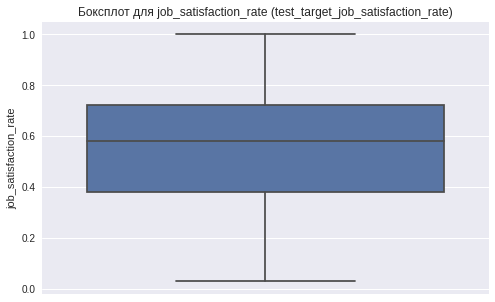

In [31]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=test_target_job_satisfaction_rate, y='job_satisfaction_rate')
plt.title('Боксплот для job_satisfaction_rate (test_target_job_satisfaction_rate)')
plt.ylabel('job_satisfaction_rate')
plt.show()

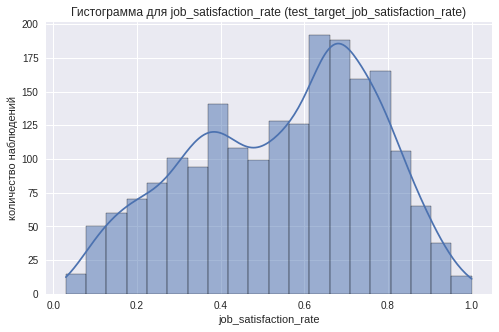

In [32]:
plt.figure(figsize=(8, 5))
sns.histplot(data=test_target_job_satisfaction_rate, x='job_satisfaction_rate', bins=20, kde=True)
plt.title('Гистограмма для job_satisfaction_rate (test_target_job_satisfaction_rate)')
plt.xlabel('job_satisfaction_rate')
plt.ylabel('количество наблюдений')
plt.show()

Выбросов в данных нет, распределние выглядит реалистично. 

Теперь проведем корреляционный анализ для тренировочного набора данных. 

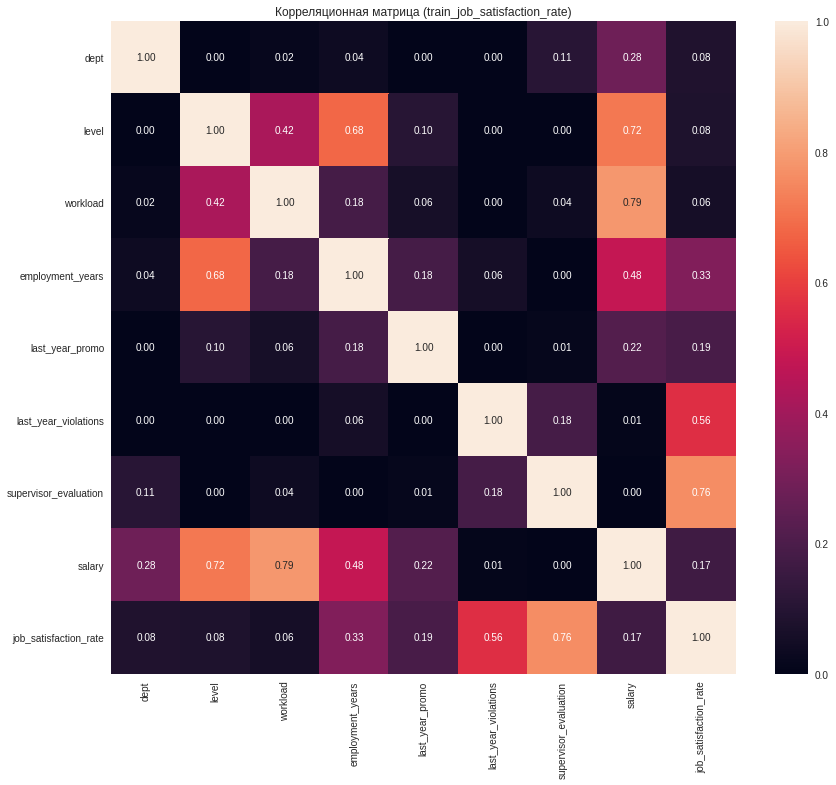

In [33]:
num_cols = ['salary', 'job_satisfaction_rate']

plt.figure(figsize=(14, 12))
sns.heatmap(train_job_satisfaction_rate.drop('id', axis=1).phik_matrix(interval_cols=num_cols), 
            annot=True, fmt='.2f')
plt.title('Корреляционная матрица (train_job_satisfaction_rate)')
plt.show()

Самое высокое значение корреляции наблюдается между признаками salary и workload, однако нельзя однозначно отнести это к мультиколлениарности. Оставим все признаки. На целевой пока натбольшее влияние оказывает supervisor_evaluation.

Итак, мы провели исследовательский анализ. В результате обнаружились выбросы, которые могут возникнуть в условиях реальной жизни, поэтому мы их оставили. 
Мультиколлинеарности в тренировочной выборке не обнаружилось. 
В некоторых признаках наблюдается сильный дисбаланс классов, однако у нас задача регрессии, и нас интересует целевая переменная, не будем изменять признак. 

## Подготовка данных

In [34]:
all_test = test_target_job_satisfaction_rate.merge(test_features, on='id', how='left')
all_test.head()

,id,job_satisfaction_rate,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,130604,0.74,technology,junior,medium,1,no,no,4,34800
1,825977,0.75,marketing,middle,high,7,no,no,5,58800
2,418490,0.60,purchasing,junior,low,1,no,no,4,19200
3,555320,0.72,technology,junior,medium,1,no,no,4,34800
4,826430,0.08,technology,junior,medium,1,no,yes,2,30000


In [35]:
RANDOM_STATE = 100

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations'] 
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

train = train_job_satisfaction_rate.drop(['id'], axis=1)
train.drop_duplicates()

X_train = train.drop('job_satisfaction_rate', axis=1)
y_train = train['job_satisfaction_rate'] 
X_test = all_test.drop(['job_satisfaction_rate','id'], axis=1)
y_test = all_test['job_satisfaction_rate'] 

Мы создали пайплайн для предобработки данных, чтобы подготовить их для задачи регрессии. Для числовых признаков заполнили пропуски средним значением, а затем применили масштабирование. Категориальные признаки ( обработали через OneHotEncoder, заполнив пропуски наиболее частой категорией. Для признака level использовали OrdinalEncoder с порядком junior, middle, senior, заполняя пропуски наиболее частой категорией, а неизвестные категории заменяли на NaN с последующей заменой на частое значение. 

## Обучение моделей

In [36]:
param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 15),
        'models__max_features': range(5, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
   
smape_scorer = make_scorer(score_func=smape, greater_is_better=False)
 
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv=5,
    scoring=smape_scorer
)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print('Лучшая модель:', grid_search.best_estimator_)
print ('Метрика на тренировочной выборке:', grid_search.best_score_*(-1))

best_model = grid_search.best_estimator_

print(f'Метрика на тестовой выборке: {round(smape(y_test, best_model.predict(X_test)),2)}')


Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                             

## Вывод по задаче 1

Итак, лучшей моделью оказалась DecisionTreeRegressor с параметрами max_depth=14, max_features=10, random_state=100. Скорее всего в данных есть нелинейные зависимости, из-за чего дерево решений сработало лучше, чем линейная регрессия. 

Для оценки ее работы мы использовали метрику smape:
- на тренировочной выборке: 14.84
- на тестовой выборке: 13.97

На тестовой выборке метрика меньше 15, а значит наша цель достигнута. 


# Задача 2: предсказание увольнения сотрудника из компании

## Загрузка данных

In [37]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

In [38]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [39]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [40]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [41]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [42]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [43]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Типы данных корректны, в некоторых столбцах обнаружены пропуски, обработаем их в пайплайне. 

##  Предобработка данных

Исследуем данные на дубликаты, для этого проверим наличие строк, которые полностью повторяют друг друга, а также изучим уникальные значения для категориальных признаков, чтобы не пропустить неявные дубликаты. 

In [44]:
train_quit.duplicated().sum()

0

In [45]:
def check_unique_values(df, columns):
    for col in columns:
        unique_vals = df[col].unique()
        print(f"Уникальные значения для {col}: {unique_vals}")        

        
categorical_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']

check_unique_values(train_quit, categorical_columns)

Уникальные значения для dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения для level: ['middle' 'junior' 'sinior']
Уникальные значения для workload: ['high' 'medium' 'low']
Уникальные значения для last_year_promo: ['no' 'yes']
Уникальные значения для last_year_violations: ['no' 'yes']
Уникальные значения для quit: ['no' 'yes']


В таблице train_quit не найдено как явных, так и неявных дубликатов. В слове senior опечатка в одной букве, исправим, чтобы не возникло путаницы. 

In [46]:
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')
check_unique_values(train_quit, categorical_columns)

Уникальные значения для dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения для level: ['middle' 'junior' 'senior']
Уникальные значения для workload: ['high' 'medium' 'low']
Уникальные значения для last_year_promo: ['no' 'yes']
Уникальные значения для last_year_violations: ['no' 'yes']
Уникальные значения для quit: ['no' 'yes']


In [47]:
test_features.duplicated().sum()

0

In [48]:
categorical_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

check_unique_values(test_features, categorical_columns)

Уникальные значения для dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения для level: ['junior' 'middle' 'sinior' nan]
Уникальные значения для workload: ['medium' 'low' 'high' ' ']
Уникальные значения для last_year_promo: ['no' 'yes']
Уникальные значения для last_year_violations: ['no' 'yes']


В таблице test_features явных дубликатов нет, однако в некоторых столбцах вместо значения nan стоит пробел, исправим это. Также, исправим орфографическую ошибку в слове senior. 

In [49]:
test_features[categorical_columns] = test_features[categorical_columns].replace(' ', np.nan)
test_features['level'] = test_features['level'].replace('sinior', 'senior')
check_unique_values(test_features, categorical_columns)

Уникальные значения для dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Уникальные значения для level: ['junior' 'middle' 'senior' nan]
Уникальные значения для workload: ['medium' 'low' 'high' nan]
Уникальные значения для last_year_promo: ['no' 'yes']
Уникальные значения для last_year_violations: ['no' 'yes']


In [50]:
test_target_quit.duplicated().sum()

0

В таблице test_target_quit явных дубликатов нет, а имеющиеся значения по столбцам могут повторять друг друга

Итак, мы провели предобработку данных. Избавились от орфографических ошибок и неявных дубликатов, явных не обнаружено. Теперь перейдем к исследовательскому анализу.

## Исследовательский анализ данных

Сначала изучим общую характеристику для количественных признаков

In [51]:
 train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [52]:
test_features.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [53]:
test_target_quit.describe()

,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000


Подозрения вызывает признак salary, максимальное значение сильно выбивается относительно других в обеих таблицах. Изучим признаки более подробно отдельно для каждой таблицы. 

<b>train_quit</b>

In [54]:
continuous_columns = ['salary']
discrete_columns = ['supervisor_evaluation', 'employment_years']
categorical_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
numeric_columns = continuous_columns + discrete_columns

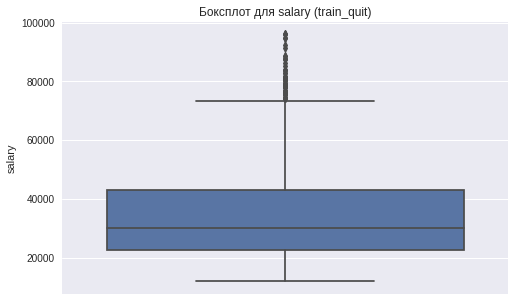

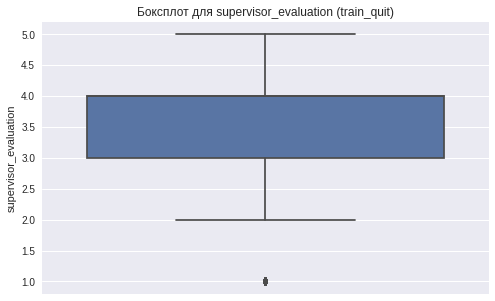

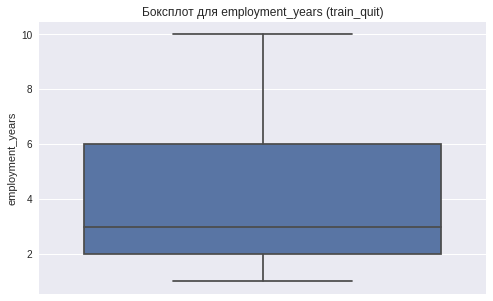

In [55]:
for col in numeric_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=train_quit, y=col)
    plt.title(f'Боксплот для {col} (train_quit)')
    plt.ylabel(col)
    plt.show()

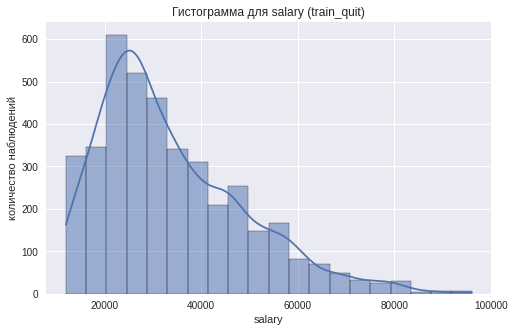

In [56]:
for col in continuous_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=train_quit, x=col, bins=20, kde=True)
    plt.title(f'Гистограмма для {col} (train_quit)')
    plt.xlabel(col)
    plt.ylabel('количество наблюдений')
    plt.show()

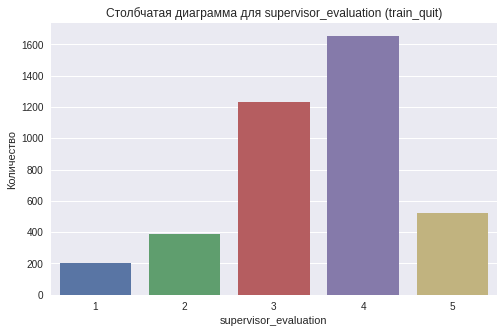

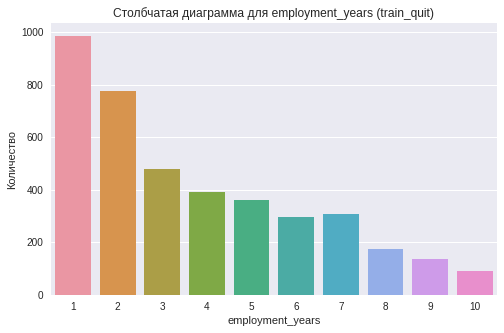

In [57]:
for col in discrete_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=train_quit, x=col)
    plt.title(f'Столбчатая диаграмма для {col} (train_quit)')
    plt.xlabel(col)
    plt.ylabel('Количество')
    plt.show()

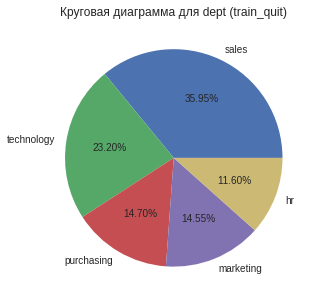

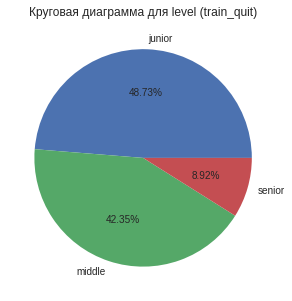

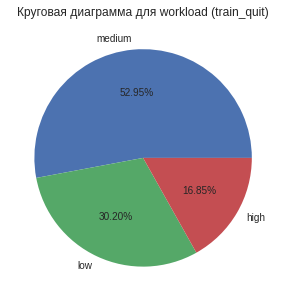

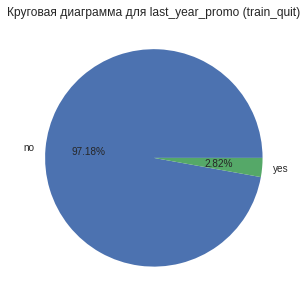

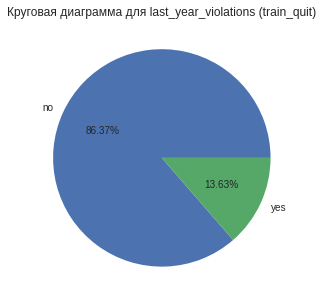

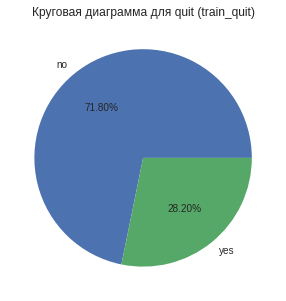

In [58]:
for col in categorical_columns:
    plt.figure(figsize=(8, 5))
    train_quit[col].value_counts().plot.pie(autopct='%1.2f%%')
    plt.title(f'Круговая диаграмма для {col} (train_quit)')
    plt.ylabel('')  
    plt.show()

В количесвенных данных есть выбросы, но выглядят они достаточно реалистично для бизнеса, всегда есть уникальные работники, оставим их, чтобы модель потом смогла работать с реальными данными. 

В категориальных признаках все соотносится реалистично, кроме признаков last_year_promo, last_year_violations. В них наблюдается сильный дисбаланс классов. Также довольно непропорциаонально соотностся значения признака quit, не уволившихся сотрудников больше чем тех, кто уволился. 

<b>test_features</b>

In [59]:
continuous_columns = ['salary']
discrete_columns = ['supervisor_evaluation', 'employment_years']
categorical_columns = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
numeric_columns = continuous_columns + discrete_columns

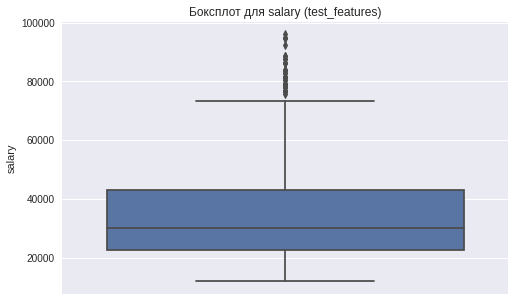

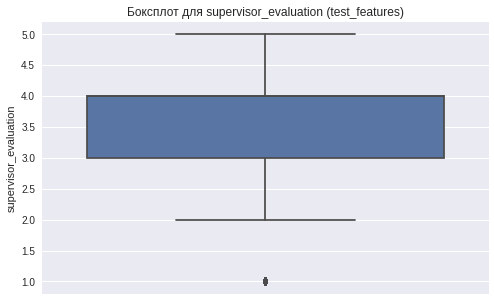

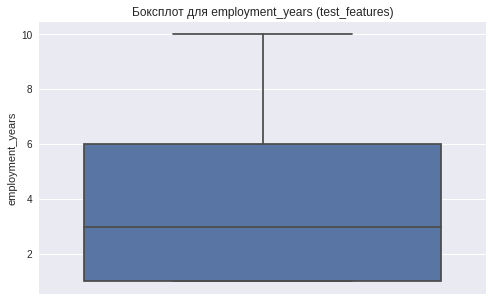

In [60]:
for col in numeric_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=test_features, y=col)
    plt.title(f'Боксплот для {col} (test_features)')
    plt.ylabel(col)
    plt.show()

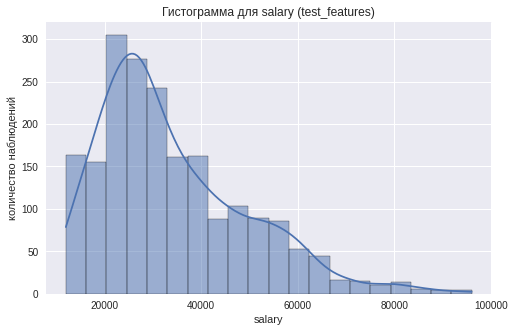

In [61]:
for col in continuous_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=test_features, x=col, bins=20, kde=True)
    plt.title(f'Гистограмма для {col} (test_features)')
    plt.xlabel(col)
    plt.ylabel('количество наблюдений')
    plt.show()

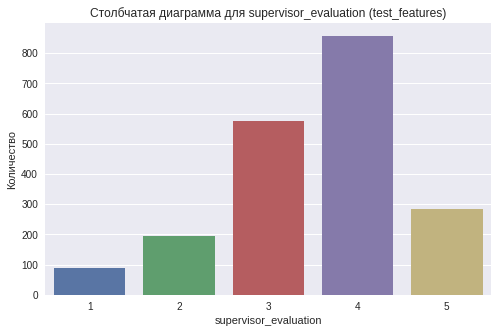

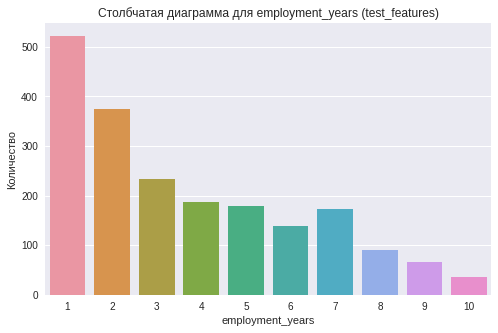

In [62]:
for col in discrete_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=test_features, x=col)
    plt.title(f'Столбчатая диаграмма для {col} (test_features)')
    plt.xlabel(col)
    plt.ylabel('Количество')
    plt.show()

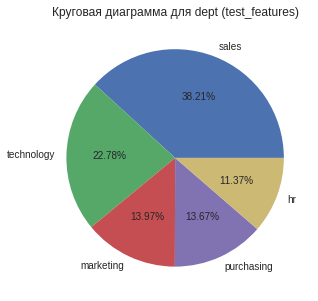

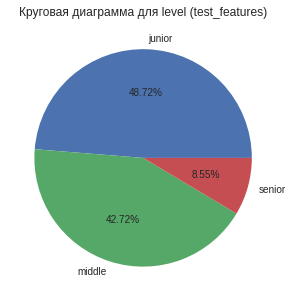

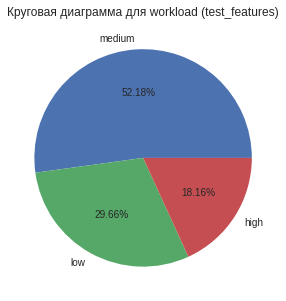

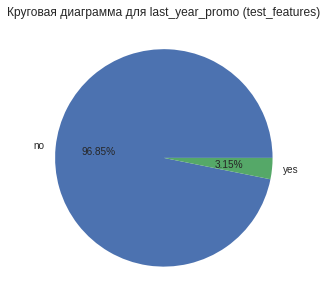

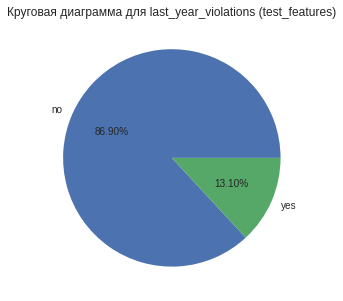

In [63]:
for col in categorical_columns:
    plt.figure(figsize=(8, 5))
    test_features[col].value_counts().plot.pie(autopct='%1.2f%%')
    plt.title(f'Круговая диаграмма для {col} (test_features)')
    plt.ylabel('')  
    plt.show()

Тут все аналогично тренировочной выборке

<b>test_target_quit</b>

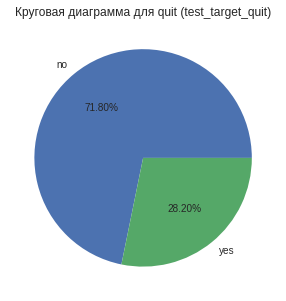

In [64]:
plt.figure(figsize=(8, 5))
test_target_quit['quit'].value_counts().plot.pie(autopct='%1.2f%%')
plt.title(f'Круговая диаграмма для quit (test_target_quit)')
plt.ylabel('')  
plt.show()

Как и в тренировочной выборке, тех кто не уволился больше. 

<b>портрет уволившегося сотрудника</b>

Text(0.5, 1.0, 'Доля увольнений по отделам (quit=yes)')

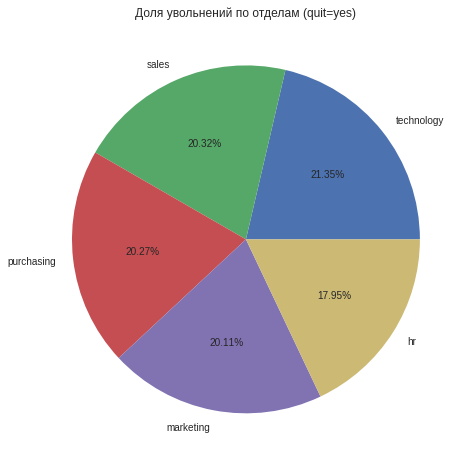

In [65]:
dept_quit = train_quit.groupby('dept')['quit'].apply(lambda x: (x == 'yes').mean()).sort_values(ascending=False)

plt.figure(figsize=(8, 8))
plt.pie(dept_quit, labels=dept_quit.index, autopct='%1.2f%%')
plt.title('Доля увольнений по отделам (quit=yes)')

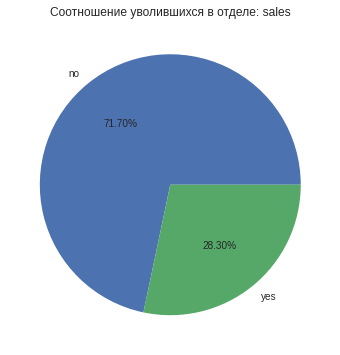

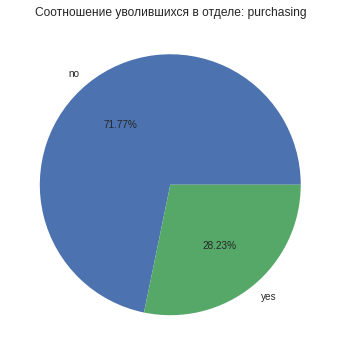

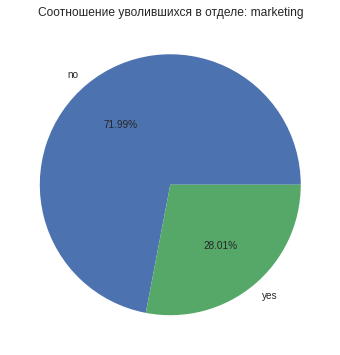

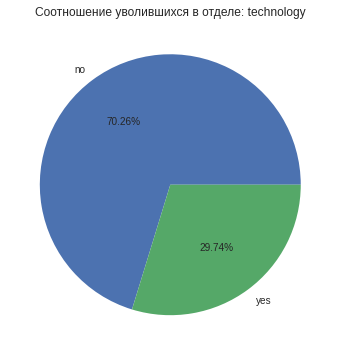

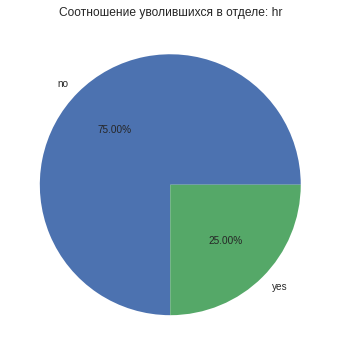

In [66]:
departments = train_quit['dept'].unique()

for dept in departments:
    dept_data = train_quit[train_quit['dept'] == dept]
    quit_counts = dept_data['quit'].value_counts()
    labels = quit_counts.index
    sizes = quit_counts.values
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.2f%%')
    plt.title(f'Соотношение уволившихся в отделе: {dept}')
    plt.show()

quit
no     37702.228412
yes    23885.106383
Name: salary, dtype: float64


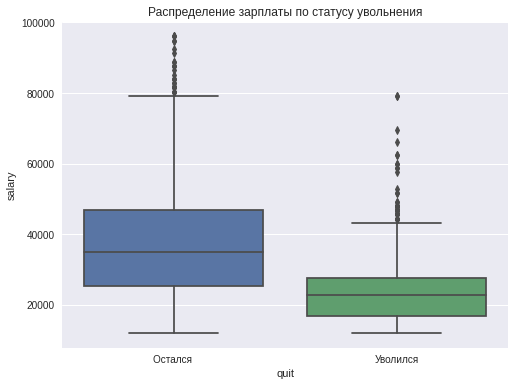

In [67]:
salary_quit = train_quit.groupby('quit')['salary'].mean()
print(salary_quit)


plt.figure(figsize=(8, 6))
sns.boxplot(data=train_quit, x='quit', y='salary',)
plt.title('Распределение зарплаты по статусу увольнения')
plt.xlabel('quit')
plt.ylabel('salary')
plt.xticks([0, 1], ['Остался ', 'Уволился'])
plt.show()

Итак, мы видим, что отдел не влияет на количество увольнений, во всех все почти одинаокво. Однако, у сотрудников, которые не увольнялись средняя зарплаты выше. Значит, уровень заработной платы влияет на решение сотрудника в увольнении. 

Мы провели исследовательский анализ данных, обнаружили выбросы, но оставили их, поскольку такие значения могут встречаться в реальности. Также, мы посмотрели, что влияет на количество увольнений. Оказалось, что отдел не несет влияния, а зарплата у тех, кто принял решение об увольнении в среднем ниже. 

Добавим признак job_satisfaction_rate, на основе предсказаний лучшей модели из прошлой задачи и исследуем, как он влияет на количество увольнений. 

## Добавление нового входного признака

In [68]:
train_quit['job_satisfaction_rate'] = best_model.predict(train_quit)

train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.6500
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.8245
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.3800
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.3800
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.6900


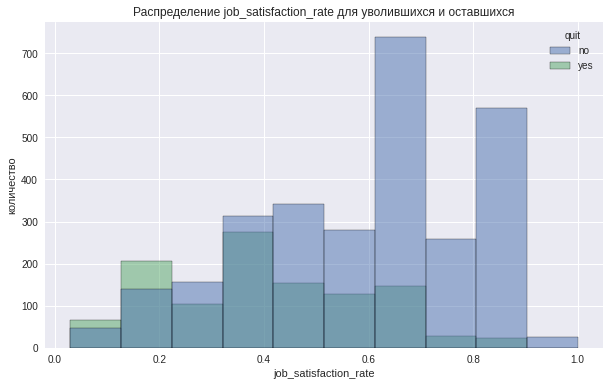

In [69]:
plt.figure(figsize=(10, 6))
sns.histplot(data=train_quit, x='job_satisfaction_rate', hue='quit', hue_order=['no', 'yes'], bins=10)
plt.title('Распределение job_satisfaction_rate для уволившихся и оставшихся')
plt.xlabel('job_satisfaction_rate')
plt.ylabel('количество')
plt.show()

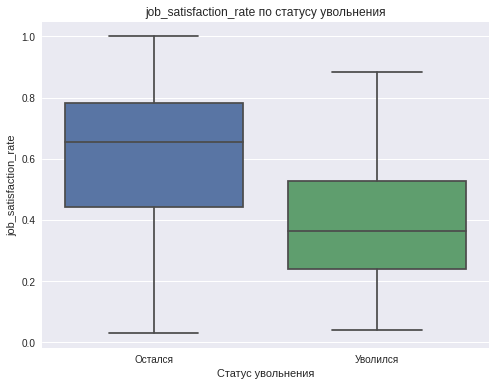

In [70]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=train_quit, x='quit', y='job_satisfaction_rate')
plt.title('job_satisfaction_rate по статусу увольнения')
plt.xlabel('Статус увольнения')
plt.ylabel('job_satisfaction_rate')
plt.xticks([0, 1], ['Остался', 'Уволился'])
plt.show()

In [71]:
train_quit.groupby('quit')['job_satisfaction_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
quit,,,,,,,,
no,2872.0,0.591764,0.206250,0.03,0.443333,0.653846,0.782500,1.0000
yes,1128.0,0.398234,0.191156,0.04,0.240000,0.363333,0.527143,0.8825


Итак, можем сказать, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. В среднем, у тех кто остался в компании, он выше. 

## Подготовка данных

In [72]:
all_test_1 = test_target_quit.merge(test_features, on='id', how='left')
all_test_1['job_satisfaction_rate'] = best_model.predict(all_test_1)

all_test_1.head()

,id,quit,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,999029,yes,technology,junior,medium,1,no,no,3,31200,0.335
1,372846,no,sales,middle,medium,10,no,yes,2,32400,0.220
2,726767,no,marketing,middle,low,7,no,no,4,20400,0.670
3,490105,no,purchasing,middle,low,7,no,no,4,19200,0.695
4,416898,yes,purchasing,junior,low,1,no,no,4,12000,0.510


In [73]:
RANDOM_STATE = 100

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

train = train_quit.drop(['id'], axis=1)
train.drop_duplicates()

X_train = train.drop('quit', axis=1)
y_train = train['quit'] 
X_test = all_test_1.drop(['quit','id'], axis=1)
y_test = all_test_1['quit'] 

Мы создали пайплайн для предобработки данных, чтобы подготовить их для задачи регрессии. Для числовых признаков заполнили пропуски средним значением, а затем применили масштабирование. Категориальные признаки ( обработали через OneHotEncoder, заполнив пропуски наиболее частой категорией. Для признака level использовали OrdinalEncoder с порядком junior, middle, senior, заполняя пропуски наиболее частой категорией, а неизвестные категории заменяли на NaN с последующей заменой на частое значение.


## Обучение модели

In [74]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {        
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__kernel': ['rbf', 'sigmoid', 'poly'],
        'preprocessor__num': [MinMaxScaler(), StandardScaler(), 'passthrough']
    }
]


randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print("Лучшая модель:", randomized_search.best_estimator_.named_steps['models'])
print("Лучшие параметры:", randomized_search.best_params_)
print("Лучший ROC-AUC :", randomized_search.best_score_)

y_pred_proba = randomized_search.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC на тестовой выборке:", test_roc_auc)

Лучшая модель: SVC(probability=True, random_state=100)
Лучшие параметры: {'preprocessor__num': StandardScaler(), 'models__kernel': 'rbf', 'models': SVC(probability=True, random_state=100)}
Лучший ROC-AUC : 0.9266594017915726
ROC-AUC на тестовой выборке: 0.9261375422272269


## Вывод по задаче 2

Итак, лучшей моделью оказалась SVC с параметрами preprocessor__num': StandardScaler(), 'models__kernel': 'rbf', 'models': SVC(probability=True, random_state=100)
Для оценки ее работы мы использовали метрику ROC-AUC:

на тренировочной выборке: 0.93
на тестовой выборке: 0.93

На тестовой выборке метрика больше 0.91, а значит наша цель достигнута.

## Общий вывод 

Мы работали над задачей для «Работа с заботой»: предсказать уровень удовлетворённости сотрудников и вероятность их увольнения, чтобы снизить отток.

- проанализировали связь удовлетворённости и увольнений. Нарисовали гистограммы и коробчатые диаграммы: уволившиеся имели меньшую удовлетворённость, чем оставшиеся — высокую. Также посмотрели увольнения по отделам и в зависимости от зарплаты, оказалось, что отдел не имеет значения, хотя зарплата и тех, кто остался в компании в среднем выше. 

- обработали данные: проверили пропуски, закодировали категории, отмасштабировали числа. Потом построили две модели: одну для предсказания удовлетворённости (job_satisfaction_rate), другую для увольнений (quit). Для удовлетворённости использовали регрессию, для увольнений — классификацию.

Вывод: низкая удовлетворённость и зарплата связаны с увольнениями. Модели помогут выявлять сотрудников в зоне риска.

Что посоветовать бизнесу:

Фокус на тех, у кого низкая удовлетворённость — предлагать бонусы или карьерный рост. Упростить опросы через приложения, чтобы собирать данные легче. Создать дашборд для отслеживания оттока в реальном времени. 